# Use of Bayesian Optimisation in developmental robotics with Explauto

This tutorial explains and implements the use of Bayesian Optimisation for exploration algorithms used in developmental robotics. 
We use the [Explauto](https://github.com/flowersteam/explauto) Python library as a toolkit to help implement exploration algorithms.

## Requirements:
- Python 2.7, Numpy, Scipy >= 0.16, Scikit-learn, [Jupyter](http://jupyter.readthedocs.io/en/latest/install.html). For users not familiar with Python, installing [Anaconda](https://www.continuum.io/downloads) for Python 2.7 includes all of them.
- [Explauto](https://github.com/flowersteam/explauto), the Python Library for Autonomous Exploration. See [installation](http://flowersteam.github.io/explauto/installation.html) section.
-  [GPy](https://github.com/SheffieldML/GPy), The Gaussian processes framework in Python and [GPyOpt](https://github.com/SheffieldML/GPyOpt) Gaussian process optimization using GPy.

You can have an issue with last version of Numpy with GPy : **ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all().**

In this case modify the ligne of the file *GPyOpt/core/bo.py* in _save_model_parameter_values(self) ligne 209 "if self.model_parameters_iterations == None:" into "if self.model_parameters_iterations **is** None:".

Let's begin with the import of all the classes and functions we will need in this notebook.

In [1]:
import matplotlib
matplotlib.use('TkAgg')
import pickle
from utils import *
from explauto.sensorimotor_model.bayesian_optimisation import BayesianOptimisation
from explauto import Environment

# SimpleArm environment
First, we will use the SimpleArm environment using only angles to move the joints.

In [2]:
# Definition of the environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

Then you need to choose the interest model.

In [3]:
# Initialization of the interest model
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'random')

For the sensorimotor model which use the Bayesian optimisation, you need to choose some parameters:

In [4]:
# The acquisition function for the optimisation, you can choose from LCB, MPI and EI.
acquisition = "LCB"
# The coefficient which do the trade-off between exploration and exploitation, 
# choose 0 for no exploration and 0.2 for a good trade off.
exploration_weight = 0.2
# Choose then number of initial points which initialize the optimisation, between 0 and 100.
k = 50
# Choose the number of iterations you want the optimisation doing,
optimisation_iterations = 1

''' This methode can take a lot of time (several minutes) so do not take k + optimisation_iterations > 100 '''

params = {'acquisition':acquisition,
          'exploration_weight' : exploration_weight,
          'initial_points': k,
          'environment' : environment,
          'optimisation_iterations': optimisation_iterations,
          'exact_feval' : True}

sm_model = BayesianOptimisation(environment.conf, **params)

Now, we will run the optimisation in the envrionment for multiple iterations. There are two parts, the random Babbling to assure exploration and the Bayesian optimisation. 

Iteration: 9
Measure of exploration: 2


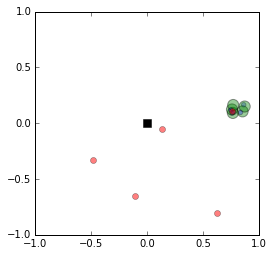

In [5]:
explored_s = []
explored_m = []
explorations = []

# Choose the number of iterations of sampling in the environment, 100 is good for this environment.
# It can take several minutes.
iterations = 10

%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1, 1.))
ax.set_ylim((-1., 1.))
ax.plot(0., 0., 'sk', ms=8)

# Bootstrap model: 1 random motor babbling
m = environment.random_motors()[0]
s = environment.update(m)
sm_model.update(m,s)
s_goal = im_model.sample()

iteration = 0
while len(explorations) < iterations:
    iteration = len(explorations)
    if (iteration) % 1 == 0:
        clear_output(wait=True)
        print "Iteration:", iteration+1
    if random() < 0.2:
        # Do random motor in 20% of the trials
        m = environment.random_motors()[0]
        s = environment.update(m)
        sm_model.update(m, s)
    else:
        # Sample a sensory goal maximizing learning progress using the interest model:
        s_goal = im_model.sample()
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.inverse_prediction(tuple(s_goal))
        # Execute this command and observe the corresponding sensory effect:
        s = environment.update(m)
        # Update the sensorimotor model:
        sm_model.update(m, s)
        # Update the interest model:
        im_model.update(hstack((m, s_goal)), hstack((m, s)))
        # Update the exploration
        explorations.append(int(compute_explo(array(explored_s), array([-1., -1.]), array([1., 1.]), gs=grid_size)))
        # Plot the goals in red:
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.5)
        explored_s += [s] # store s for later evaluation
        explored_m += [m] # store m for later ploting
        # Plot the final sensori effect in green 
        ax.add_patch(Circle(tuple(s), 0.05, fc="g", alpha=0.4))
        # Do the treatment of the points explored during the optimisation
        S = []
        size = len( sm_model.dataset )
        for index in range(size - optimisation_iterations, size):
            S.append(sm_model.dataset.get_y(index- 1))
        for s in S:
            explored_s += [s] # store s for later evaluation
            explored_m += [m] # store m for later ploting
            ax.add_patch(Circle(tuple(s), 0.02, fc="b", alpha=0.3))
            explorations.append(int(compute_explo(array(explored_s), array([-1., -1.]), array([1., 1.]), gs=grid_size)))
        
explorations = explorations[:iterations]
exploration = explorations[-1]
print "Measure of exploration:", exploration

You can see the sensorial space, in red the goals, in blue the points explored by the algorithm and in green the final answer of the optimisation to one goal. 

To plot some dimensions of the motor space.

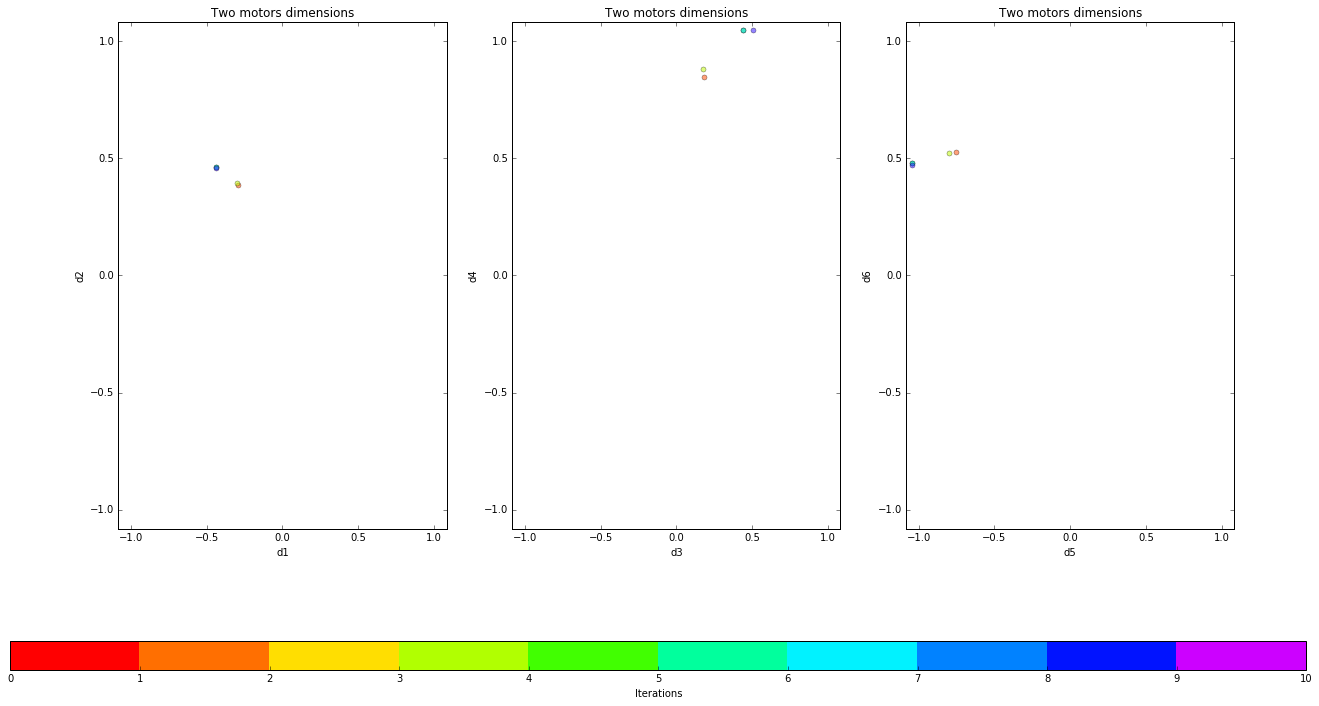

In [6]:
plot_motor_space(explored_m)

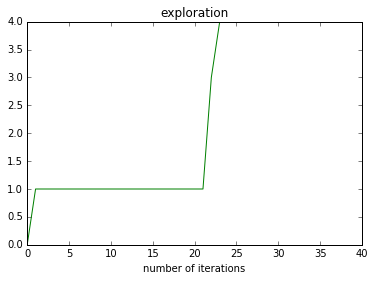

In [6]:
# Plot the exploration trough the learning
x  = [j for j in range(len(explorations))]
plt.plot(x, explorations,'g')
plt.xlabel("number of iterations")
plt.title("exploration")

You can see the exploration trough the iterations, it's measured by cuting the space into cases and counting the number of cases were the ball has been moved.

If you want to measure the competence gained thanks to the learning, which correspond to the distance to the goal of multiple iterations of inference. 

{'boxes': [<matplotlib.lines.Line2D at 0x7f6b03ea2650>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6b03f11190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6b03f72c10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6b03efb890>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6b03e97f10>,
  <matplotlib.lines.Line2D at 0x7f6b03e8d710>]}

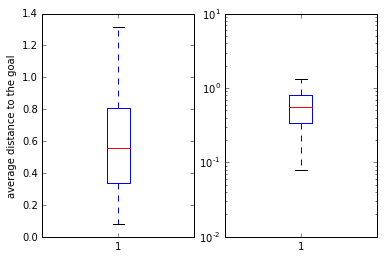

In [8]:
''' Choose the models you want to test '''

competence = []

# Use the dataset of the learning 
dataset = sm_model.dataset

# To test with the basic model which is the nearest naighbor model
paramNN = "NN"

# To test the Bayesian optimisation
paramBO = {'acquisition': "LCB", 'exploration_weight' : 0, 'initial_points': 50,
    'environment' : environment, 'optimisation_iterations': 1, 'exact_feval' : True}

param = paramNN

# Number iterations of inference
j1 = 100

# Number of inferences
b = 20

competence.append(mesure_competence(dataset,param,environment,j, b))

plt.subplot(121)
plt.ylabel("average distance to the goal")
plt.boxplot(competence)

plt.subplot(122)
plt.yscale('log')
plt.boxplot(competence)

You can see the boxplot of the distance to the goal the method has achieved on the data collected precedently.

# ArmBall 

For second environment we can use the environment ArmBall which is a arm which can move a ball with its extremity. The joints use DMPs to move, so the extremity follows a trajectory.

In [1]:
import matplotlib
matplotlib.use('TkAgg')

from utils import *
from explauto.sensorimotor_model.bayesian_optimisation import BayesianOptimisation
import pickle
from explauto.environment import available_configurations
from explauto import Environment
from time import *

In [2]:
# Definition of the environment

n_joints = 7      # Number of joints
n_dmp_basis = 3   # Number of basis per joint
goal_size = 1.    # Size of the 2D goal space

environment = ArmBall(n_joints, n_dmp_basis, goal_size)

In [3]:
# Initialization of the interest model
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'random')

In [4]:
# The acquisition function for the optimisation, you can choose from LCB, MPI and EI.
acquisition = "LCB"
# The coefficient which do the trade-off between exploration and exploitation, 
# choose 0 for no exploration and 0.2 for a good trade off.
exploration_weight = 0.2
# Choose then number of initial points which initialize the optimisation, between 0 and 100.
k = 5
# Choose the number of iterations you want the optimisation doing,
optimisation_iterations = 1

''' This methode can take a lot of time (some hours) so do not take k + optimisation_iterations > 100 '''

params = {'acquisition':acquisition,
          'exploration_weight' : exploration_weight,
          'initial_points': k,
          'environment' : environment,
          'optimisation_iterations': optimisation_iterations,
          'exact_feval' : True}

sm_model = BayesianOptimisation(environment.conf, **params)

Now, we will run the optimisation in the envrionment for multiple iterations. There are two parts, the random Babbling to assure exploration and the Bayesian optimisation. 

Iteration: 11


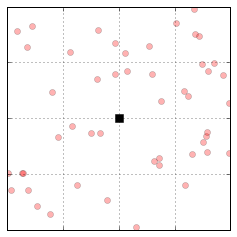

Number of ball catch: 0
Measure of exploration: 0


In [5]:
explored_s = []
explored_m = []
explorations = []
number_balls_catched = []

# Choose the number of iterations of sampling in the environment, 1000 is good for this environment.
# It can take several hours.
iterations = 10

%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1, 1.))
ax.set_ylim((-1., 1.))
ax.plot(0., 0., 'sk', ms=8)


# Bootstrap model: 1 random motor babbling
m = environment.random_motors()[0]
s = environment.update(m)
sm_model.update(m,s)

s_goal = im_model.sample()

iteration = 0

while iteration < iterations:
    iteration = len(explorations)
    if (iteration) % 1 == 0:
        clear_output(wait=True)
        print "Iteration:", iteration+1
    if random() < 0.2:
        # Do random motor babbling while the ball has not been grasped, and then in 20% of the trials
        m = environment.random_motors()[0]
        s = environment.update(m)
        sm_model.update(m, s)
        explored_m += [m] # store m for later ploting
        if abs(s[-1] - 0.6) > 0.001 : # if the ball has been moved by the arm, we plot its trajectory and last position
            explored_s += [s] # store s for later evaluation
            ax.plot(environment.s_traj[:,0], environment.s_traj[:,1], lw=2, alpha=0.1)
            ax.add_patch(Circle(tuple(environment.s_traj[-1,:]), 0.1, fc="b", alpha=0.3))

        explorations.append(int(compute_explo(array(explored_s), array([-1., -1.]), array([1., 1.]), gs=grid_size)))
        number_balls_catched.append(len(explored_s))
    else:
        # Sample a sensory goal maximizing learning progress using the interest model:
        s_goal = im_model.sample()
        # Infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.inverse_prediction(tuple(s_goal))
        # Execute this command and observe the corresponding sensory effect:
        s = environment.update(m)
        # Update the sensorimotor model:
        sm_model.update(m, s)
        # Update the interest model:
        im_model.update(hstack((m, s_goal)), hstack((m, s)))
        # Plot the goals in red:
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.3)

        S = []
        size = len( sm_model.dataset )
        for index in range(size - optimisation_iterations, size):
            S.append(sm_model.dataset.get_y(index-1))
        for s in S:
            explored_m += [m] # store m for later ploting
            if abs(s[-1] - 0.6) > 0.001: # if the ball has been moved by the arm, we plot its trajectory and last position
                explored_s += [s] # store s for later evaluation
                explorations.append(int(compute_explo(array(explored_s), array([-1., -1.]), array([1., 1.]), gs=grid_size)))
                number_balls_catched.append(len(explored_s))
                ax.plot(environment.s_traj[:,0], environment.s_traj[:,1], lw=2, alpha=0.1)
                ax.add_patch(Circle(tuple(environment.s_traj[-1,:]), 0.1, fc="b", alpha=0.3))



explorations = explorations[:iterations]
number_balls_catched = number_balls_catched[:iterations]


plt.xticks(linspace(-1., 1., 5))
plt.yticks(linspace(-1., 1., 5))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()
plt.ioff()
plt.show()

Nb_balls = len(explored_s)
exploration = int(compute_explo(array(explored_s), array([-1., -1.]), array([1., 1.]), gs=grid_size))
print "Number of ball catch:", Nb_balls
print "Measure of exploration:", exploration

You can see the sensorial space, in red the goals, in blue the points explored by the algorithm and in green the final answer of the optimisation to one goal. 

To plot some dimensions of the motor space.

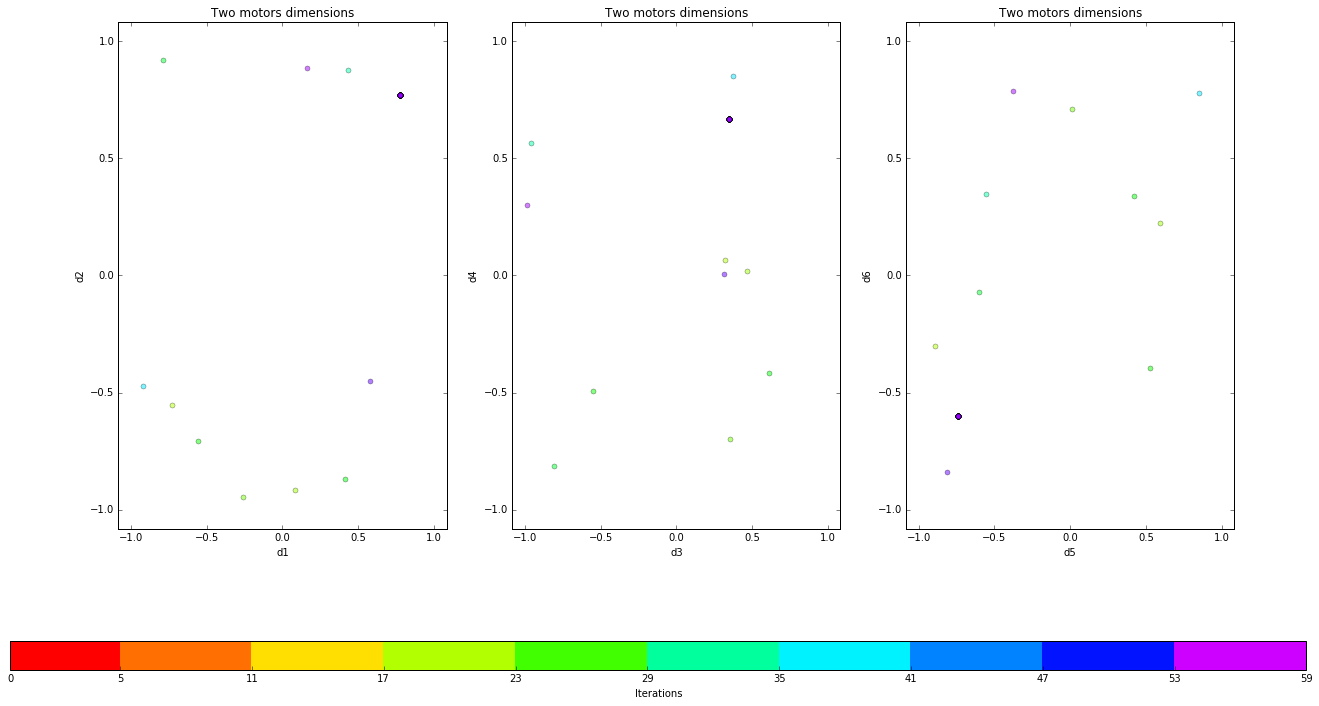

In [6]:
plot_motor_space(explored_m)

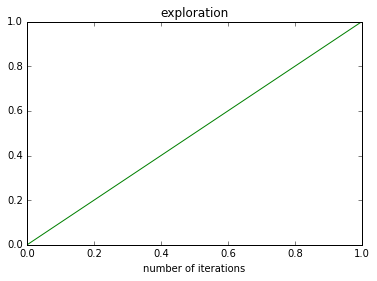

In [18]:
# Plot the exploration trough the learning
x  = [j for j in range(len(explorations))]
plt.plot(x, explorations,'g')
plt.xlabel("number of iterations")
plt.title("exploration")

You can see the exploration trough the iterations, it's measured by cuting the space into cases and counting the number of cases were the ball has been moved.

{'boxes': [<matplotlib.lines.Line2D at 0x7f6b0397a710>],
 'caps': [<matplotlib.lines.Line2D at 0x7f6b03985810>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f6b03990b10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6b039904d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6b0397aad0>,
  <matplotlib.lines.Line2D at 0x7f6b039851d0>]}

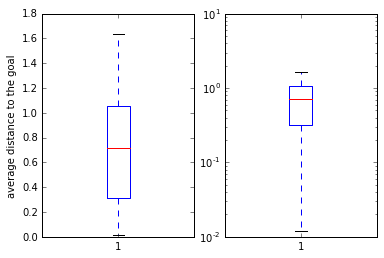

In [16]:
''' Choose the models you want to test '''
competence = []

# Use the dataset of the learning 
dataset = sm_model.dataset

# To test with the basic model which is the nearest naighbor model
paramNN = "NN"

# To test the Bayesian optimisation
paramBO = {'acquisition': "LCB", 'exploration_weight' : 0, 'initial_points': 50,
    'environment' : environment, 'optimisation_iterations': 1, 'exact_feval' : True}

param = paramNN

# Number iterations of inference
j1 = 100

# Number of inferences
b = 20

competence.append(mesure_competence(dataset,param,environment,j, b))

plt.subplot(121)
plt.ylabel("average distance to the goal")
plt.boxplot(competence)

plt.subplot(122)
plt.yscale('log')
plt.boxplot(competence)

You can see the boxplot of the distance to the goal the method has achieved on the data collected precedently.